# <span style='color:blue'> CDS 522 Text and Speech Analytics Project : </span>
## <span style='color:blue'> Text Analytics for Suicidal Thoughts </span>

**Prepared by: 
Chin Yi Xiang,
Ling Hui Ting**

# Emotions Analysis

## Import Packages and Define Helper Function

### Import Packages

In [27]:
# import required packages
#warnings :)
import warnings
warnings.filterwarnings('ignore')

# for df purpose
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()

# for text processing
import nltk
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# for graph plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#pip install Pillow
from PIL import Image

# for storing intermediate results
import pickle

# for notebook function
from IPython.display import display, clear_output
import time

### Defining Helper Functions

In [28]:
def print_bold(text):
    text_bold = '\x1b[1;30;47m'+text+ '\x1b[0m'
    print(text_bold)
def glance(x,n=5):
    try:
        iterator = iter(x)
    except:
        print(x)
        return
    else:
        if type(x) == str or len(str(x)) <= 50:
            print(x)
            return
        if type(x) == dict:
            iterator = x.items()
        i = 0
        for ele in iterator:
            if i >= n:
                break
            glance(ele,n)
            i += 1

## Preparing Lexicon

In [3]:
# Read files # Download files from NRC Emotion and Sentiment Lexicons
fear = pd.read_csv('emotions/fear-scores.txt', 
                   header = None, sep="\t", names=['English','Scores'])
fear['Emotions']= "Fear"


anger = pd.read_csv('emotions/anger-scores.txt', 
                   header = None, sep="\t", names=['English','Scores'])
anger['Emotions']= "Anger"


disgust = pd.read_csv('emotions/disgust-scores.txt', 
                   header = None, sep="\t", names=['English','Scores'])
disgust['Emotions']= "Disgust"


sadness = pd.read_csv('emotions/sadness-scores.txt', 
                   header = None, sep="\t", names=['English','Scores'])
sadness['Emotions']= "Sadness"


surprise = pd.read_csv('emotions/surprise-scores.txt', 
                   header = None, sep="\t", names=['English','Scores'])
surprise['Emotions']= "Surprise"


In [4]:
# Remove the words where probabilily < 20% of the emotions
fear= fear.drop(fear[fear['Scores'] < 0.2].index, inplace=False).reset_index(drop=True)
anger= anger.drop(anger[anger['Scores'] < 0.2].index, inplace=False).reset_index(drop=True)
disgust= disgust.drop(disgust[disgust['Scores'] < 0.2].index, inplace=False).reset_index(drop=True)
sadness= sadness.drop(sadness[sadness['Scores'] < 0.2].index, inplace=False).reset_index(drop=True)
surprise= surprise.drop(surprise[surprise['Scores'] < 0.2].index, inplace=False).reset_index(drop=True)

In [5]:
# combined all the files
df_emo = fear.append(anger).append(disgust).append(sadness).append((surprise), ignore_index=True)
df_emo

,English,Scores,Emotions
0,torture,0.984,Fear
1,terrorist,0.972,Fear
2,horrific,0.969,Fear
3,terrorism,0.969,Fear
4,terrorists,0.969,Fear
...,...,...,...
5732,sweet,0.203,Surprise
5733,purity,0.203,Surprise
5734,nullify,0.203,Surprise
5735,morals,0.203,Surprise


In [6]:
# convert to pivot
pivot_emo = df_emo.pivot_table(index=['English'], columns= ['Emotions'], values=['Scores'], aggfunc='sum')
pivot_emo = pivot_emo.fillna(value=0)
pivot_emo

Scores                                
Emotions     Anger Disgust   Fear Sadness Surprise
English                                           
aaaaaaah     0.000     0.0  0.344   0.000    0.000
aaaah        0.000     0.0  0.234   0.000    0.000
abandon      0.000     0.0  0.531   0.703    0.000
abandoned    0.222     0.0  0.534   0.828    0.000
abandonment  0.438     0.0  0.609   0.859    0.523
...            ...     ...    ...     ...      ...
yelp         0.000     0.0  0.281   0.000    0.516
yousuck      0.578     0.0  0.000   0.000    0.000
yucky        0.000     0.0  0.000   0.203    0.000
zany         0.000     0.0  0.000   0.000    0.555
zeal         0.000     0.0  0.000   0.000    0.484

[3424 rows x 5 columns]

In [7]:
# rename the columns and index
pivot_emo.reset_index(inplace = True)
pivot_emo.columns=['Words','Anger','Disgust','Fear','Sadness','Surprise']
pivot_emo

,Words,Anger,Disgust,Fear,Sadness,Surprise
0,aaaaaaah,0.000,0.0,0.344,0.000,0.000
1,aaaah,0.000,0.0,0.234,0.000,0.000
2,abandon,0.000,0.0,0.531,0.703,0.000
3,abandoned,0.222,0.0,0.534,0.828,0.000
4,abandonment,0.438,0.0,0.609,0.859,0.523
...,...,...,...,...,...,...
3419,yelp,0.000,0.0,0.281,0.000,0.516
3420,yousuck,0.578,0.0,0.000,0.000,0.000
3421,yucky,0.000,0.0,0.000,0.203,0.000
3422,zany,0.000,0.0,0.000,0.000,0.555


In [8]:
# add Emotions column (max scores)
emo = pivot_emo
emo['Emotions'] = emo.iloc[:,1:].idxmax(axis=1)
emo

,Words,Anger,Disgust,Fear,Sadness,Surprise,Emotions
0,aaaaaaah,0.000,0.0,0.344,0.000,0.000,Fear
1,aaaah,0.000,0.0,0.234,0.000,0.000,Fear
2,abandon,0.000,0.0,0.531,0.703,0.000,Sadness
3,abandoned,0.222,0.0,0.534,0.828,0.000,Sadness
4,abandonment,0.438,0.0,0.609,0.859,0.523,Sadness
...,...,...,...,...,...,...,...
3419,yelp,0.000,0.0,0.281,0.000,0.516,Surprise
3420,yousuck,0.578,0.0,0.000,0.000,0.000,Anger
3421,yucky,0.000,0.0,0.000,0.203,0.000,Sadness
3422,zany,0.000,0.0,0.000,0.000,0.555,Surprise


In [9]:
# check if balanced emotions
emo['Emotions'].value_counts()

Fear        932
Anger       796
Sadness     722
Disgust     528
Surprise    446
Name: Emotions, dtype: int64

## Annotate Emotions

In [13]:
data_clean = pd.read_pickle('pickles/df_clean.pkl')
data_clean

0       [fucking, hate, holiday, season, first, thanks...
1          [dm, add, discord, want, help, talk, cofactor]
2       [nearly, always, battled, depression, got, old...
3       [future, nothing, impenetrable, fog, look, bac...
4       [always, fighting, sister, always, lash, mom, ...
                              ...                        
1293    [since, felt, depressed, almost, took, life, w...
1294    [nt, know, reaching, time, seem, appropriate, ...
1295    [dont, believe, afterlife, stay, night, fear, ...
1296    [nt, think, actually, kill, thats, scared, nt,...
1297    [wan, na, die, badly, everytim, hear, someone,...
Name: text, Length: 1283, dtype: object

In [15]:
# annotate data
def annotate_emotion(wordlist):
    annotated_list = []
    emotion_by_count = {
        'Anger': 0,
        'Fear': 0,
        'Disgust': 0,
        'Sadness': 0,
        'Surprise': 0,
    }
    emotion_by_score = {
        'Anger': 0,
        'Fear': 0,
        'Disgust': 0,
        'Sadness': 0,
        'Surprise': 0,
    }
    for word in wordlist:
        emo_row = emo[emo["Words"] == word]
        if len(emo_row) == 0:
            continue
        else:
            emo_row = emo_row.iloc[0]
        annotated_list.append({
            'word': word,
            'Anger': emo_row['Anger'],
            'Fear': emo_row['Fear'],
            'Disgust': emo_row['Disgust'],
            'Sadness': emo_row['Sadness'],
            'Surprise': emo_row['Surprise'],
            'Emotions': emo_row['Emotions']            
        })
        emotion_by_count[emo_row['Emotions']] += 1
        for ele in emotion_by_score:
            emotion_by_score[ele] += emo_row[ele]
    
    return{
        'annotated_list': annotated_list,
        'emotion_by_count': emotion_by_count,
        'emotion_by_score': emotion_by_score,
    }
        
#data_split = data_clean.str.split(' ')
df_annotate = pd.DataFrame(data_clean)
annotated = []
emotion_by_count = []
emotion_by_score = []
for i in df_annotate.index:
    row = df_annotate.loc[i].iloc[0]
    res = annotate_emotion(row)
    annotated.append(res['annotated_list'])
    emotion_by_count.append(res['emotion_by_count'])
    emotion_by_score.append(res['emotion_by_score'])
df_annotate['annotated'] = annotated
df_annotate['emotion_by_count'] = emotion_by_count
df_annotate['emotion_by_score'] = emotion_by_score
df_annotate

,text,annotated,emotion_by_count,emotion_by_score
0,"[fucking, hate, holiday, season, first, thanks...","[{'word': 'hate', 'Anger': 0.828, 'Fear': 0.48...","{'Anger': 4, 'Fear': 0, 'Disgust': 0, 'Sadness...","{'Anger': 3.694, 'Fear': 4.452999999999999, 'D..."
1,"[dm, add, discord, want, help, talk, cofactor]","[{'word': 'discord', 'Anger': 0.57600000000000...","{'Anger': 1, 'Fear': 1, 'Disgust': 0, 'Sadness...","{'Anger': 0.5760000000000001, 'Fear': 0.203, '..."
2,"[nearly, always, battled, depression, got, old...","[{'word': 'battled', 'Anger': 0.71200000000000...","{'Anger': 2, 'Fear': 9, 'Disgust': 2, 'Sadness...","{'Anger': 5.419, 'Fear': 7.61, 'Disgust': 3.32..."
3,"[future, nothing, impenetrable, fog, look, bac...","[{'word': 'unable', 'Anger': 0.0, 'Fear': 0.0,...","{'Anger': 0, 'Fear': 0, 'Disgust': 0, 'Sadness...","{'Anger': 0.636, 'Fear': 1.226, 'Disgust': 0.6..."
4,"[always, fighting, sister, always, lash, mom, ...","[{'word': 'fighting', 'Anger': 0.868, 'Fear': ...","{'Anger': 3, 'Fear': 2, 'Disgust': 0, 'Sadness...","{'Anger': 3.0869999999999997, 'Fear': 2.659999..."
...,...,...,...,...
1293,"[since, felt, depressed, almost, took, life, w...","[{'word': 'depressed', 'Anger': 0.297, 'Fear':...","{'Anger': 2, 'Fear': 1, 'Disgust': 0, 'Sadness...","{'Anger': 1.7599999999999998, 'Fear': 2.518000..."
1294,"[nt, know, reaching, time, seem, appropriate, ...","[{'word': 'danger', 'Anger': 0.0, 'Fear': 0.80...","{'Anger': 3, 'Fear': 13, 'Disgust': 0, 'Sadnes...","{'Anger': 6.568, 'Fear': 13.158000000000003, '..."
1295,"[dont, believe, afterlife, stay, night, fear, ...","[{'word': 'fear', 'Anger': 0.5, 'Fear': 0.828,...","{'Anger': 0, 'Fear': 7, 'Disgust': 0, 'Sadness...","{'Anger': 2.9939999999999998, 'Fear': 6.571000..."
1296,"[nt, think, actually, kill, thats, scared, nt,...","[{'word': 'kill', 'Anger': 0.0, 'Fear': 0.9620...","{'Anger': 3, 'Fear': 6, 'Disgust': 0, 'Sadness...","{'Anger': 2.221, 'Fear': 5.1640000000000015, '..."


In [16]:
#show example
sample_row = df_annotate.iloc[0]
print('Before annotate: \n','-'*20)
print(sample_row['text'])
print('After annotates: \n','-'*20)
print(sample_row['annotated'])
print('\nemotion_by_count', sample_row['emotion_by_count'])
print('\nemotion_by_score', sample_row['emotion_by_score'])


Before annotate: 
 --------------------
['fucking', 'hate', 'holiday', 'season', 'first', 'thanksgiving', 'nothing', 'thankful', 'everyone', 'hate', 'hate', 'would', 'thankful', 'would', 'fucking', 'die', 'already', 'next', 'christmas', 'one', 'time', 'year', 'people', 'actually', 'nice', 'day', 'go', 'back', 'shitty', 'fucking', 'hate', 'new', 'year', 'day', 'start', 'new', 'year', 'loneliness', 'despair', 'really', 'wish', 'could', 'fucking', 'die', 'done', 'fucking', 'life']
After annotates: 
 --------------------
[{'word': 'hate', 'Anger': 0.828, 'Fear': 0.484, 'Disgust': 0.695, 'Sadness': 0.6559999999999999, 'Surprise': 0.0, 'Emotions': 'Anger'}, {'word': 'hate', 'Anger': 0.828, 'Fear': 0.484, 'Disgust': 0.695, 'Sadness': 0.6559999999999999, 'Surprise': 0.0, 'Emotions': 'Anger'}, {'word': 'hate', 'Anger': 0.828, 'Fear': 0.484, 'Disgust': 0.695, 'Sadness': 0.6559999999999999, 'Surprise': 0.0, 'Emotions': 'Anger'}, {'word': 'die', 'Anger': 0.0, 'Fear': 0.7659999999999999, 'Disgust':

In [17]:
df_annotate['domain_emotion_by_count'] = df_annotate['emotion_by_count'].apply(lambda d: max(d,key=d.get))
df_annotate['domain_emotion_by_score'] = df_annotate['emotion_by_score'].apply(lambda d: max(d,key=d.get))
df_annotate

,text,annotated,emotion_by_count,emotion_by_score,domain_emotion_by_count,domain_emotion_by_score
0,"[fucking, hate, holiday, season, first, thanks...","[{'word': 'hate', 'Anger': 0.828, 'Fear': 0.48...","{'Anger': 4, 'Fear': 0, 'Disgust': 0, 'Sadness...","{'Anger': 3.694, 'Fear': 4.452999999999999, 'D...",Sadness,Sadness
1,"[dm, add, discord, want, help, talk, cofactor]","[{'word': 'discord', 'Anger': 0.57600000000000...","{'Anger': 1, 'Fear': 1, 'Disgust': 0, 'Sadness...","{'Anger': 0.5760000000000001, 'Fear': 0.203, '...",Anger,Anger
2,"[nearly, always, battled, depression, got, old...","[{'word': 'battled', 'Anger': 0.71200000000000...","{'Anger': 2, 'Fear': 9, 'Disgust': 2, 'Sadness...","{'Anger': 5.419, 'Fear': 7.61, 'Disgust': 3.32...",Fear,Fear
3,"[future, nothing, impenetrable, fog, look, bac...","[{'word': 'unable', 'Anger': 0.0, 'Fear': 0.0,...","{'Anger': 0, 'Fear': 0, 'Disgust': 0, 'Sadness...","{'Anger': 0.636, 'Fear': 1.226, 'Disgust': 0.6...",Sadness,Sadness
4,"[always, fighting, sister, always, lash, mom, ...","[{'word': 'fighting', 'Anger': 0.868, 'Fear': ...","{'Anger': 3, 'Fear': 2, 'Disgust': 0, 'Sadness...","{'Anger': 3.0869999999999997, 'Fear': 2.659999...",Anger,Anger
...,...,...,...,...,...,...
1293,"[since, felt, depressed, almost, took, life, w...","[{'word': 'depressed', 'Anger': 0.297, 'Fear':...","{'Anger': 2, 'Fear': 1, 'Disgust': 0, 'Sadness...","{'Anger': 1.7599999999999998, 'Fear': 2.518000...",Anger,Sadness
1294,"[nt, know, reaching, time, seem, appropriate, ...","[{'word': 'danger', 'Anger': 0.0, 'Fear': 0.80...","{'Anger': 3, 'Fear': 13, 'Disgust': 0, 'Sadnes...","{'Anger': 6.568, 'Fear': 13.158000000000003, '...",Fear,Fear
1295,"[dont, believe, afterlife, stay, night, fear, ...","[{'word': 'fear', 'Anger': 0.5, 'Fear': 0.828,...","{'Anger': 0, 'Fear': 7, 'Disgust': 0, 'Sadness...","{'Anger': 2.9939999999999998, 'Fear': 6.571000...",Fear,Fear
1296,"[nt, think, actually, kill, thats, scared, nt,...","[{'word': 'kill', 'Anger': 0.0, 'Fear': 0.9620...","{'Anger': 3, 'Fear': 6, 'Disgust': 0, 'Sadness...","{'Anger': 2.221, 'Fear': 5.1640000000000015, '...",Fear,Fear


In [18]:
#Show different by count and by score
df_annotate[df_annotate['domain_emotion_by_count'] != df_annotate['domain_emotion_by_score']]

,text,annotated,emotion_by_count,emotion_by_score,domain_emotion_by_count,domain_emotion_by_score
12,"[almost, tried, overdose, last, night, found, ...","[{'word': 'die', 'Anger': 0.0, 'Fear': 0.76599...","{'Anger': 0, 'Fear': 2, 'Disgust': 0, 'Sadness...","{'Anger': 1.148, 'Fear': 5.263999999999999, 'D...",Sadness,Fear
16,"[pain, physically, every, day, struggle, find,...","[{'word': 'pain', 'Anger': 0.0, 'Fear': 0.594,...","{'Anger': 0, 'Fear': 7, 'Disgust': 0, 'Sadness...","{'Anger': 1.4209999999999998, 'Fear': 6.968000...",Sadness,Fear
18,"[serious, live, philippine, tried, hanging, ch...","[{'word': 'hanging', 'Anger': 0.636, 'Fear': 0...","{'Anger': 0, 'Fear': 3, 'Disgust': 0, 'Sadness...","{'Anger': 1.48, 'Fear': 2.719, 'Disgust': 1.12...",Fear,Sadness
25,"[one, hand, would, nt, mind, dying, sleep, nat...","[{'word': 'dying', 'Anger': 0.455, 'Fear': 0.9...","{'Anger': 0, 'Fear': 1, 'Disgust': 1, 'Sadness...","{'Anger': 0.455, 'Fear': 0.948, 'Disgust': 1.1...",Fear,Disgust
34,"[feeling, worthlessghost, three, match, week, ...","[{'word': 'feeling', 'Anger': 0.0, 'Fear': 0.3...","{'Anger': 0, 'Fear': 1, 'Disgust': 0, 'Sadness...","{'Anger': 0.0, 'Fear': 1.195, 'Disgust': 0.0, ...",Sadness,Fear
...,...,...,...,...,...,...
1270,"[usually, nt, post, kind, scared, thanks, soci...","[{'word': 'scared', 'Anger': 0.0, 'Fear': 0.73...","{'Anger': 2, 'Fear': 8, 'Disgust': 6, 'Sadness...","{'Anger': 3.2399999999999998, 'Fear': 6.503000...",Fear,Sadness
1276,"[dont, want, live, anymore, keep, thinking, tr...","[{'word': 'hate', 'Anger': 0.828, 'Fear': 0.48...","{'Anger': 2, 'Fear': 7, 'Disgust': 0, 'Sadness...","{'Anger': 3.5920000000000005, 'Fear': 10.197, ...",Sadness,Fear
1277,"[one, year, ago, today, tried, end, life, rece...","[{'word': 'dying', 'Anger': 0.455, 'Fear': 0.9...","{'Anger': 0, 'Fear': 2, 'Disgust': 0, 'Sadness...","{'Anger': 0.455, 'Fear': 1.151, 'Disgust': 0.6...",Fear,Surprise
1288,"[feel, like, giving, want, die, tired, trying,...","[{'word': 'die', 'Anger': 0.0, 'Fear': 0.76599...","{'Anger': 0, 'Fear': 1, 'Disgust': 0, 'Sadness...","{'Anger': 0.0, 'Fear': 2.235, 'Disgust': 0.422...",Sadness,Fear


## Domain Emotions by Count

In [19]:
# domain emotion by count 
emo_counts =df_annotate['domain_emotion_by_count'].value_counts(normalize=True)
emo_counts

Sadness     0.435698
Fear        0.300857
Anger       0.172253
Surprise    0.063913
Disgust     0.027280
Name: domain_emotion_by_count, dtype: float64

Text(0.5, 0, 'Percentage')

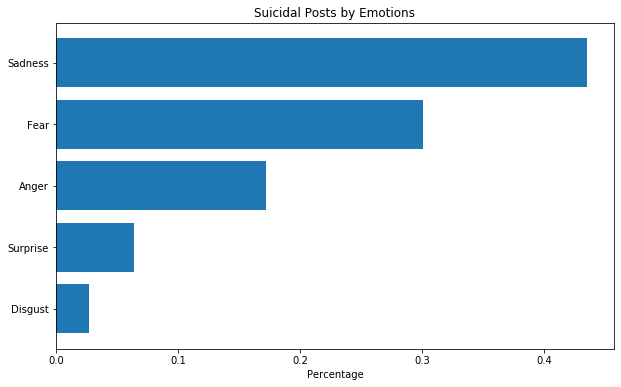

In [20]:
#bar chart - emotion by count
title = 'Suicidal Posts by Emotions' 
emo_counts.sort_values().plot(kind='barh', figsize=(10,6), title=title,width =0.8)
plt.xlabel('Percentage')

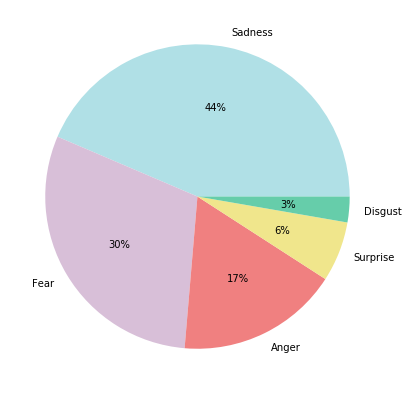

In [21]:
# piechart - emotion by count 
colors = ("powderblue","thistle","lightcoral","khaki","mediumaquamarine")
plt.pie(emo_counts, labels = emo_counts.index, autopct='%1.0f%%',colors=colors) #,textprops = dict(color ="grey"))
fig = plt.gcf()
fig.set_size_inches(7,7)

## Domain Emotions by Score

In [22]:
# domain emotion by scores
emo_score_counts =df_annotate['domain_emotion_by_score'].value_counts(normalize=True)
emo_score_counts


Sadness     0.465316
Fear        0.347623
Anger       0.123928
Surprise    0.033515
Disgust     0.029618
Name: domain_emotion_by_score, dtype: float64

Text(0.5, 0, 'Percentage')

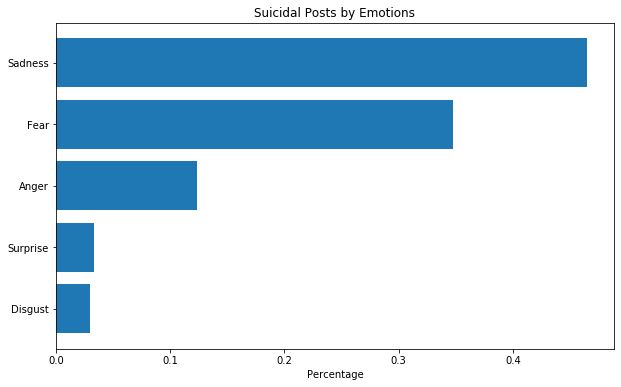

In [23]:
#bar chart - emotion by score
title = 'Suicidal Posts by Emotions' 
emo_score_counts.sort_values().plot(kind='barh', figsize=(10,6), title=title, width=0.8)
plt.xlabel('Percentage')

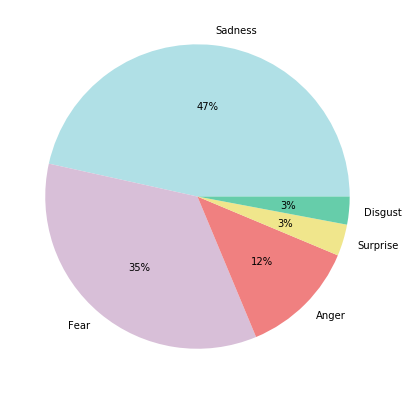

In [24]:
# piechart - emotion by score
colors = ("powderblue","thistle","lightcoral","khaki","mediumaquamarine")
plt.pie(emo_score_counts,labels = emo_counts.index, autopct='%1.0f%%',colors=colors) #,textprops = dict(color ="grey"))
fig = plt.gcf()
fig.set_size_inches(7,7)

## Save Intermediate Results

In [29]:
# save files for later use
emotion_post = pd.DataFrame(df_annotate['domain_emotion_by_count'])
emotion_post.to_pickle('pickles/emotion.pkl')

emotion_score =pd.DataFrame(df_annotate['domain_emotion_by_score'])
emotion_score.to_pickle('pickles/emotion_score.pkl')

In [30]:
# User this line to save to html
!jupyter nbconvert --to html_ch --output-dir='.\html' "3. Emotions Analysis.ipynb"

[NbConvertApp] Converting notebook 3. Emotions Analysis.ipynb to html_ch
[NbConvertApp] Writing 453869 bytes to .\html\3. Emotions Analysis.html


# ----------------------------------------------END----------------------------------------------------------